In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')  # Download the Punkt tokenizer if you haven't already

from nltk.tokenize import sent_tokenize

import re
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from PIL import Image


# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Alright let's review the scraped data.

In [39]:
data = pd.read_csv("pubmed_data_full.csv")
data

,PubMedID,Title,URL,Abstract
0,37899090,Therapy with direct oral anticoagulants for se...,https://pubmed.ncbi.nlm.nih.gov/37899090,Antiphospholipid syndrome (APS) is a systemic ...
1,37878348,Treatment Outcomes With Licensed and Unlicense...,https://pubmed.ncbi.nlm.nih.gov/37878348,Stimulants (methylphenidate and amphetamines) ...
2,37866803,"AdipoRon and ADP355, adiponectin receptor agon...",https://pubmed.ncbi.nlm.nih.gov/37866803,Adiponectin replacement therapy holds the pote...
3,37864589,Exploring the logic and conducting a comprehen...,https://pubmed.ncbi.nlm.nih.gov/37864589,The potential benefits of adiponectin replacem...
4,37846549,Evaluation of pentamidine tolerability and eff...,https://pubmed.ncbi.nlm.nih.gov/37846549,Intravenous pentamidine is used for prophylaxi...
...,...,...,...,...
5832,1964663,Therapeutic application of subcutaneous low-mo...,https://pubmed.ncbi.nlm.nih.gov/1964663,Fifty patients presenting with acute deep-vein...
5833,2563187,"Relative efficacy of, and some adverse reactio...",https://pubmed.ncbi.nlm.nih.gov/2563187,Although it is a common belief that all antihy...
5834,3124679,Advanced ovarian cancer: long-term results of ...,https://pubmed.ncbi.nlm.nih.gov/3124679,To determine the efficacy of a 6-month course ...
5835,3431880,The analgesic effect of amitriptyline on chron...,https://pubmed.ncbi.nlm.nih.gov/3431880,The efficacy of amitriptyline was evaluated in...


Let's check if we have null values.

In [40]:
data.isnull().sum()

PubMedID      0
Title         0
URL           0
Abstract    256
dtype: int64

Alright we see 256 entries have NaN for the abstract so let's drop these.

In [41]:
data.dropna(inplace=True)
data

,PubMedID,Title,URL,Abstract
0,37899090,Therapy with direct oral anticoagulants for se...,https://pubmed.ncbi.nlm.nih.gov/37899090,Antiphospholipid syndrome (APS) is a systemic ...
1,37878348,Treatment Outcomes With Licensed and Unlicense...,https://pubmed.ncbi.nlm.nih.gov/37878348,Stimulants (methylphenidate and amphetamines) ...
2,37866803,"AdipoRon and ADP355, adiponectin receptor agon...",https://pubmed.ncbi.nlm.nih.gov/37866803,Adiponectin replacement therapy holds the pote...
3,37864589,Exploring the logic and conducting a comprehen...,https://pubmed.ncbi.nlm.nih.gov/37864589,The potential benefits of adiponectin replacem...
4,37846549,Evaluation of pentamidine tolerability and eff...,https://pubmed.ncbi.nlm.nih.gov/37846549,Intravenous pentamidine is used for prophylaxi...
...,...,...,...,...
5832,1964663,Therapeutic application of subcutaneous low-mo...,https://pubmed.ncbi.nlm.nih.gov/1964663,Fifty patients presenting with acute deep-vein...
5833,2563187,"Relative efficacy of, and some adverse reactio...",https://pubmed.ncbi.nlm.nih.gov/2563187,Although it is a common belief that all antihy...
5834,3124679,Advanced ovarian cancer: long-term results of ...,https://pubmed.ncbi.nlm.nih.gov/3124679,To determine the efficacy of a 6-month course ...
5835,3431880,The analgesic effect of amitriptyline on chron...,https://pubmed.ncbi.nlm.nih.gov/3431880,The efficacy of amitriptyline was evaluated in...


And let's see if the scraper didn't take any duplicates.

In [42]:
data['Abstract'].describe()

count                                                  5581
unique                                                 5579
top       We identified 16 randomized placebo-controlled...
freq                                                      2
Name: Abstract, dtype: object

two duplicates let's look at those


In [43]:
duplicates = data.groupby('Abstract').count()
mask = duplicates['PubMedID'] >= 2
duplicates[mask]

,PubMedID,Title,URL
Abstract,,,
"The optimal strategy for revascularization in infrainguinal chronic limb-threatening ischemia (CLTI) remains debatable. Comparative trials are scarce, and daily decisions are often made using anecdotal or low-quality evidence. We searched multiple databases through May 7, 2017, for prospective studies with at least 1-year follow-up that evaluated patient-relevant outcomes of infrainguinal revascularization procedures in adults with CLTI. Independent pairs of reviewers selected articles and extracted data. Random-effects meta-analysis was used to pool outcomes across studies. We included 44 studies that enrolled 8602 patients. Periprocedural outcomes (mortality, amputation, major adverse cardiac events) were similar across treatment modalities. Overall, patients with infrapopliteal disease had higher patency rates of great saphenous vein graft at 1 and 2 years (primary: 87%, 78%; secondary: 94%, 87%, respectively) compared with all other interventions. Prosthetic bypass outcomes were notably inferior to vein bypass in terms of amputation and patency outcomes, especially for below knee targets at 2 years and beyond. Drug-eluting stents demonstrated improved patency over bare-metal stents in infrapopliteal arteries (primary patency: 73% vs 50% at 1 year), and was at least comparable to balloon angioplasty (66% primary patency). Survival, major amputation, and amputation-free survival at 2 years were broadly similar between endovascular interventions and vein bypass, with prosthetic bypass having higher rates of limb loss. Overall, the included studies were at moderate to high risk of bias and the quality of evidence was low. There are major limitations in the current state of evidence guiding treatment decisions in CLTI, particularly for severe anatomic patterns of disease treated via endovascular means. Periprocedural (30-day) mortality, amputation, and major adverse cardiac events are broadly similar across modalities. Patency rates are highest for saphenous vein bypass, whereas both patency and limb salvage are markedly inferior for prosthetic grafting to below the knee targets. Among endovascular interventions, percutaneous transluminal angioplasty and drug-eluting stents appear comparable for focal infrapopliteal disease, although no studies included long segment tibial lesions. Heterogeneity in patient risk, severity of limb threat, and anatomy treated renders direct comparison of outcomes from the current literature challenging. Future studies should incorporate both limb severity and anatomic staging to best guide clinical decision making in CLTI.",2,2,2
We identified 16 randomized placebo-controlled trials investigating cannabinoids as symptomatic treatment in multiple sclerosis (MS). There is evidence that nabiximols oromucosal spray may reduce subjective symptoms of spasticity and that dronabinol is effective against neuropathic pain in patients with MS. The existing treatment system in Denmark is in conformity with the existing data and there is not sufficient evidence to modify it.,2,2,2


In [44]:
data['Abstract'] = data['Abstract'].str.strip()
data = data.drop_duplicates(subset='Abstract')
data['Abstract'].describe()

count                                                  5579
unique                                                 5579
top       Antiphospholipid syndrome (APS) is a systemic ...
freq                                                      1
Name: Abstract, dtype: object

Now all duplicates and rows with NaN values have been removed

Let's inspect the top 30 most common words in the abstracts.

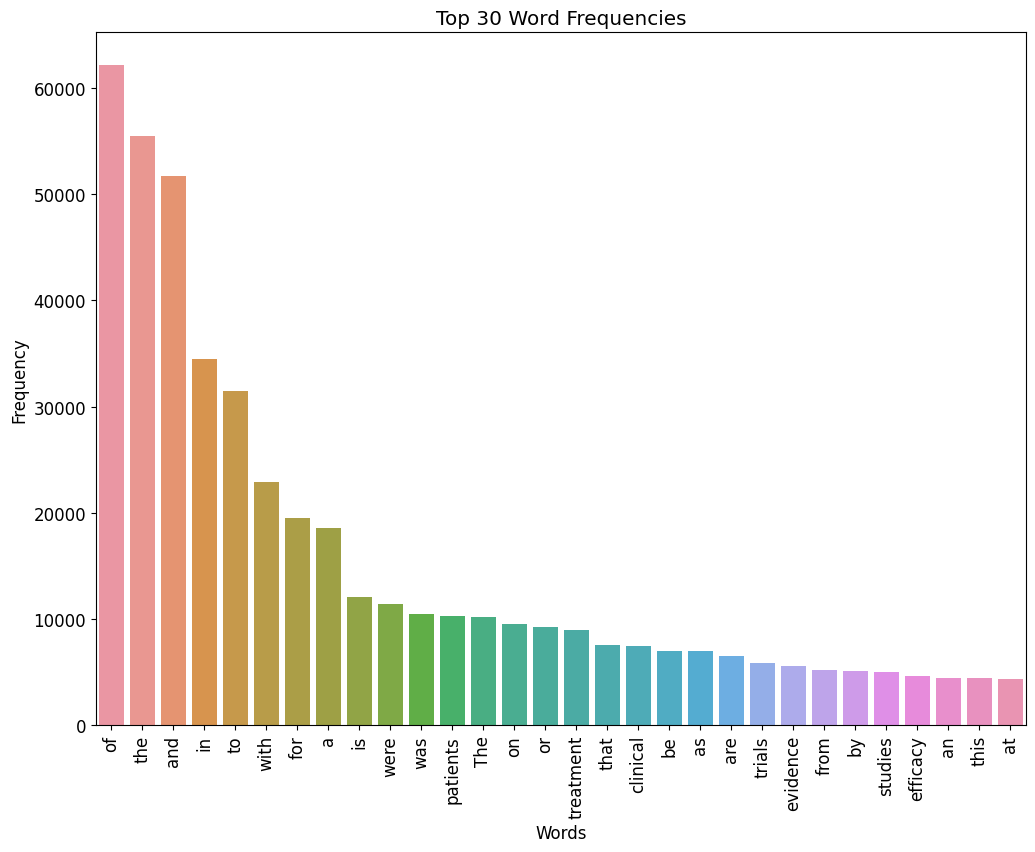

In [45]:
word_freq = {}
for sentence in data["Abstract"]:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

As we see stopwords take up most of the spots in the 30 most recurring words. Let's remove these to paint a better picture of the 30 most common words in my corpus excluding stopwords.

In [46]:
def clean_text(text):
    if type(text) != str or text=='':
        return ''

    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"(?<=\b\w) n't", " not", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("what\'s ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("&", "and", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub(r'i\'m', 'i am', text)
    #remove stopwords and apply lemmatization instead of stemming because it is more accurate in most cases.
    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [word for word in text if word.lower() not in stopwords_set]
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return " ".join(text)

In [47]:
stopwords_set = set(stopwords.words('english'))
print(len(stopwords_set))

179


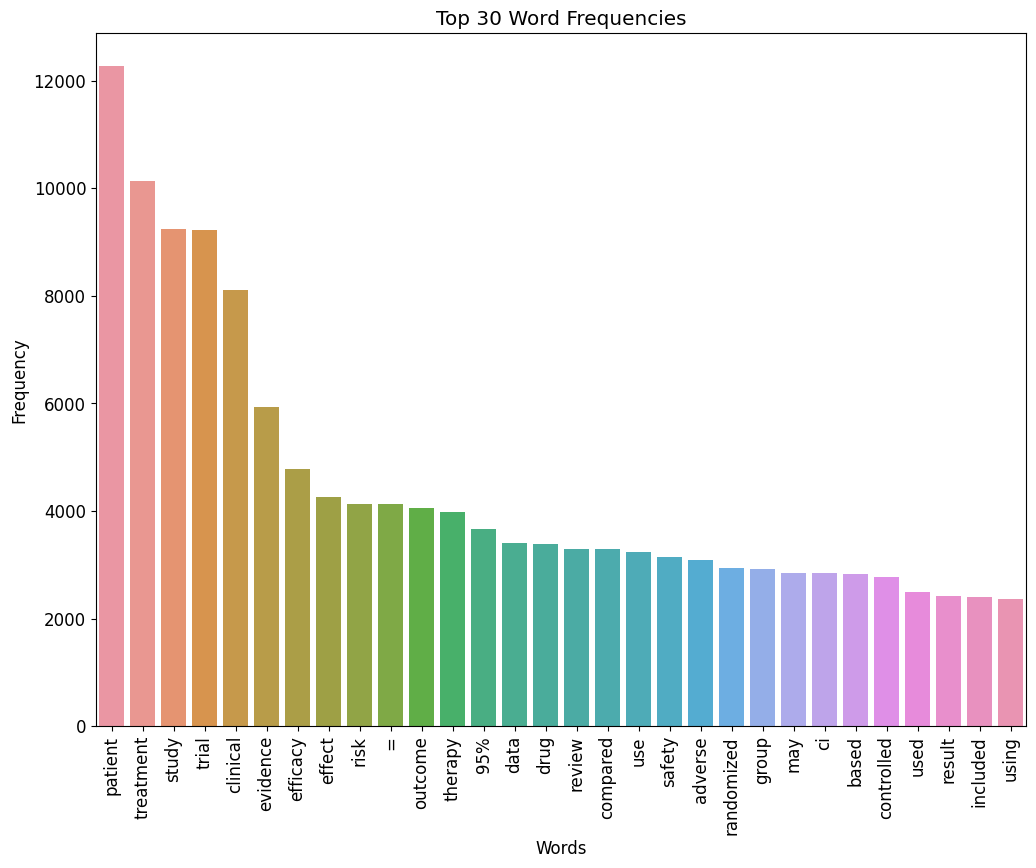

In [48]:
cleaned_data = data['Abstract'].apply(clean_text)
word_freq = {}
for sentence in cleaned_data:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

Here we see now that more words we would expect from a corpus based on drug trials and mechanisms of action can be seen in the top 30 let's make a wordcloud to see these distribution in a different way. to see if we can spot other important themes in our data.

In [49]:

from wordcloud import WordCloud


total_text = " ".join(abstract for abstract in data['Abstract'])

word_cloud = WordCloud().generate(total_text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


ValueError: Only supported for TrueType fonts

And here like we see in the barplot the main themes of the corpus center around patient, treatment, efficacy, clinical trial, result which is what we would expect from data which is meant to center around clinical trial results and mechanisms of actions of drug test. Let's see if we can already get a clue about the most frequent topics by generating a wordcloud from the titles.

In [ ]:
cleaned_titles = data['Title'].apply(clean_text)

total_title = " ".join(title for title in cleaned_titles)

word_cloud = WordCloud().generate(total_title)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

ValueError: Only supported for TrueType fonts

So also here to main themes are reviews and clinical trials of certain treatment based on EBM and MOA.

<a name='1'></a>
## So after the cleaning function is used several things are altered or removed.
1. The text is converted to lowercase, HTML tags are removed.
3. Contractions like "n't" or "'ll" are expanded to their full form.<br>
5. Possessive forms like "'s" are removed.
6. The symbol "&" is replaced with the word "and".
8. Repeated periods are reduced to a single period.
10. Stop words are removed, and the remaining words are lemmatized.<br>
In summary the preprocessing code performs various text cleaning operations, including the removal of HTML tags, contraction expansion, and lemmatization. 
Now you can observe that the highest frequency word is no longer a stopword and it's frequency is only 20% of the original most frequent word "of". Now one could argue that removing stopwords is a good thing since most of them don't carry much context, which is true most of the times  and combined with lemmatization it would make the corpus and each document smaller leading to the possibility of more context to the LLM in the future. But consider the following example and chain of thought where I will reason that some stop words do carry context and in the context of this retrieval augmented generation and removing certain stopwords could invert the conclusion of a research paper.

In [50]:
print(data['Abstract'].iloc[4])
print(cleaned_data.iloc[4])

Intravenous pentamidine is used for prophylaxis against Pneumocystis jirovecii pneumonia, an infection seen in hematopoietic stem cell transplant recipients. Pentamidine is partially metabolized by CYP2C19, which is vulnerable to pharmacogenetic variation. This retrospective study evaluated allogeneic hematopoietic stem cell transplant patients who received intravenous pentamidine as P. jirovecii pneumonia prophylaxis. The primary objective was the association between CYP2C19 phenotype and discontinuation of pentamidine due to drug-related side effects based on univariate logistic regression (N = 81). Ten patients (12.3%) discontinued pentamidine because of side effects. There was no difference in discontinuation between phenotype groups (p = 0.18) or discontinuation due to side effects (p = 0.76). Overall, no association was seen between phenotypes and pentamidine-related side effects (p = 0.475). Drug discontinuation rates and P. jirovecii pneumonia infection rates were low.
intraven

Now the first abstract is not cleaned and the second abstract is cleaned with stopwords removed and the words lemmatized. First the conclusion of a paper often contain the key findings of the research with a summary a context change here resulting from stopword removal could prove catastrophic in drug justification based on EBM where we look a results of studies to find a solution or a justification to our own problem. Now let's look at the conclusion of the original abstract where it is stated that Overall, no association was seen between phenotypes and pentamidine-related side effects (p = 0.475) and the cleaned_abstract which concludes overall, association seen phenotype pentamidine-related side effect (p = 0.475). This cleaned abstracts conclusion is the complete opposite which says there is association in side effects and giving this text as context for the LLM could result in a wrong justification of a fact based on incorrect information due to the removal of stopwords. Perhaps a more domain specific list of stopwords could be used where these kinds of "important stopwords" which don't lose context when removed are present. BUT this is only for the abstract giving context to the LLM what if I still clean the text but specifically for the embedding, even though the conclusion might be off the embedding would still match a high similarity to the fact or question needing justification and then I would retrieve the k most similar uncleaned abstracts or chuncks for the full context. For example consider the following fact needing justification or correction: pentamidine is discontinued due to drug-related side effects from stemming from the CYP2C19 phenotype would still match high similarity to the cleaned and embedded abstract with the wrong conclusion but the conclusion is irrelevant at this stage we just want to match k most similar documents for context and removing stopwords for efficient embedding and maintaining context while removing noise in the embedding could prove beneficial. Then when the k most similar abstract embeddings are matched to the question their original abstracts or chunks thereof with the correct information would would be used as context. so in summary since the primary goal in the initial step is to maximize the similarity matching for retrieval purposes, then cleaning the text by removing stopwords and irrelevant details could prove beneficial.

Proposed structure:

Chunking: First, perform chunking on the original uncleaned abstracts. This will divide each abstract into smaller sections as not to fill up the entire context window while preserving the original context. Each chunk will be stored  with an id, which can be useful for tracking.

Cleaning: After chunking the data, I would start with cleaning, for example removing stopwords. Cleaning is only for the text embeddings to remove the noise of stopwords from the embedding context to be better matched to a fact.

Embedding: Once you have cleaned the data, generate embeddings for each cleaned chunk. These will be used to calculate similarities and retrieve the most relevant original chunks when passed to the LLM for context.

tuple Structure: To maintain the link between cleaned chunks and their corresponding uncleaned versions, create a structured data format, such as a tuple. This format will take the shape of the chunk ID and the embedding of the cleaned chunk. This structure might enable me to match the cleaned chunks with questions and retrieve the uncleaned context.

In [51]:
unique_words_set = set(" ".join(data['Abstract']).split())
unique_words_count = len(unique_words_set)

unique_words_set_cleaned = set(" ".join(cleaned_data).split())
unique_words_count_cleaned = len(unique_words_set_cleaned)
print("Unique words count with stopwords= " + str(unique_words_count))
print("Unique words count without stopwords and further cleaning= "+ str(unique_words_count_cleaned))

Unique words count with stopwords= 100266
Unique words count without stopwords and further cleaning= 90317


So we can see cleaning indeed shrinks the corpus and might make word embeddings more concise on their similarity with a fact without the stopwords. 

Let's first what the average sentence and abstract lengths are in our raw abstracts to see how badly we would need chunking for a regular LLM model with 4096 tokens.

In [52]:
row_count = data.shape[0]
total_abstract_length = 0
total_sentence_length = 0
sentence_count = 0
for abstract in data['Abstract']:
    sentences = sent_tokenize(abstract)
    total_abstract_length += len(abstract.split())
    sentence_count += len(sentences)
    total_sentence_length += sum(len(sentence.split()) for sentence in sentences)

        
avg_abstract_length = total_abstract_length / row_count
avg_sentence_length = total_sentence_length / sentence_count


print("Average sentence length " + str(avg_sentence_length))
print("Average abstract "+ str(avg_abstract_length))


Average sentence length 22.76748215502177
Average abstract 275.5633626097867


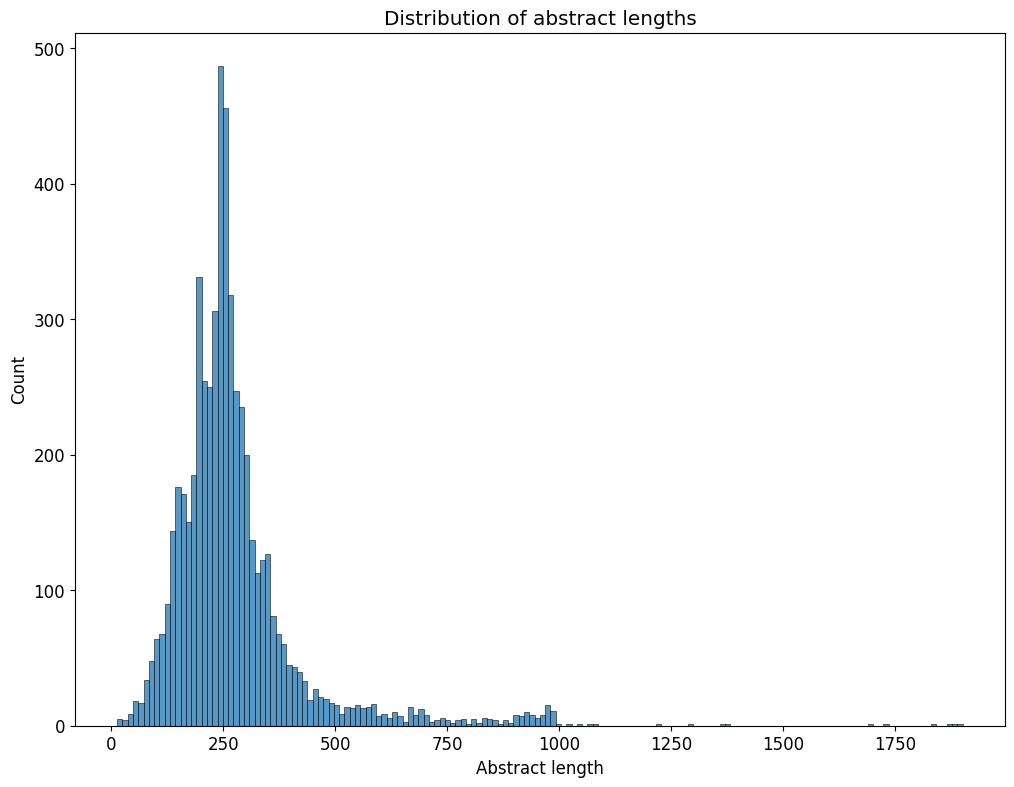

In [53]:
abstract_lengths = [len(abstract.split()) for abstract in data['Abstract']]

sns.histplot(abstract_lengths)
plt.title("Distribution of abstract lengths")
plt.xlabel("Abstract length")
plt.ylabel("Count")
plt.show()

In [67]:
abstract_lengths.sort()
largest = abstract_lengths[len(abstract_lengths) -1]
smallest = abstract_lengths[0]
print("Smallest abstract length: " + str(smallest))
print("Largest abstract length: " + str(largest))


Smallest abstract length: 13
Largest abstract length: 1901


So we need some degree of chunking since even though the average abstract length isn't too big there are some outliers and these could fill up our context window coupled with some other abstracts in the same category if found similar. Now let's review if the smaller abstracts contain any relevant information regarding drug efficacies and EBM trials or if they are pretexts of the paper they are discussing with no scientific data such as test and trial results included.

In [64]:
max_length = 100

# Filter the DataFrame
short_abstracts = data[data['Abstract'].apply(lambda x: len(x.split())) < max_length]

# Display the short abstracts
short_abstracts


,PubMedID,Title,URL,Abstract
345,35692074,Bronchial thermoplasty: State of the art.,https://pubmed.ncbi.nlm.nih.gov/35692074,"Since the publication of a sham-controlled, ra..."
1371,31880233,Dissociating the Clinical Role and Economic Va...,https://pubmed.ncbi.nlm.nih.gov/31880233,No funding supported the writing of this comme...
1642,31017622,Evaluation of Ivermectin vs Permethrin for Tre...,https://pubmed.ncbi.nlm.nih.gov/31017622,Is the use of ivermectin in patients infested ...
1774,30561146,Effectiveness of pharmaceutical interventions ...,https://pubmed.ncbi.nlm.nih.gov/30561146,Meibomian gland dysfunction is one of the most...
1914,30120774,Getting to Long-Term Effectiveness and Safety ...,https://pubmed.ncbi.nlm.nih.gov/30120774,Attention-deficit hyperactivity disorder (ADHD...
...,...,...,...,...
5706,10961441,Clinical experience with Cerebrolysin.,https://pubmed.ncbi.nlm.nih.gov/10961441,Cerebrolysin is a peptidergic drug which displ...
5721,10744306,"Clinical measurement, statistical analysis, an...",https://pubmed.ncbi.nlm.nih.gov/10744306,The National Acute Spinal Cord Injury Studies ...
5776,9594927,Lipid altering or antioxidant vitamins for pat...,https://pubmed.ncbi.nlm.nih.gov/9594927,Evidence supports the idea that substantial be...
5791,9196574,Interferon beta: the current position.,https://pubmed.ncbi.nlm.nih.gov/9196574,Treatments that reduce disease activity in mul...


In [60]:
for index, row in short_abstracts.iterrows():
    print(row['Abstract'])


Since the publication of a sham-controlled, randomized trial (AIR2) and subsequent marketing approval by the US Food and Drug Administration, we have significantly advanced our understanding of bronchial thermoplasty (BT)'s scientific basis, long-term safety, clinical efficacy and cost-effectiveness. In particular, the last 2 years have witnessed multiple research publications on several of these counts. In this review, we critically appraise our evolving understanding of BT's biologic underpinnings and clinical impact, offer an evidence-based patient workflow guide for the busy pulmonologist and highlight both current challenges as well as potential solutions for the researcher and the clinician.
No funding supported the writing of this commentary. The author has nothing to disclose.
Is the use of ivermectin in patients infested with scabies associated with improved clinical and safety outcomes compared with permethrin? Both ivermectin and permethrin treatment were associated with hig

And while reading through these small abstracts I see that it's a mix. Some abstracts are indeed pretexts but others already provide trial results and medicine efficacies in them so they are useful to keep. And even as pretexts the LLM could use this as a way to explain there have been tests of that drug in your usecase and even though it cannot explain the drugs workings you can find the paper which discusses these results.

By applying an effective chunking strategy, the similarity search can get as close as possible to capture the essence of the user’s query. If the chunks are too small or too large, it may lead to imprecise search results or missed opportunities to surface relevant content. Now I will first try and make a justification pipeline without cleaning the abstracts before embeddings this will add complexity but results can be compared later. Chunking length will be avg_abstract_length / 2 with an overlap of 50. I believe this will chunk up the documents enough while having overlap to ensure all necessary documents with trial results and MOA methods are also taken with the conclusion regarding a drugs efficacy. Right now I am contemplating the embedding and LLM model to try in my first pipeline. I think for the LLM I will use llama2 since it's the most powerful LLM opensourced, and the for embedding I think will be using the llama-cpp to keep it within the LLama familly. And for vector store I think of using FAISS since it's an efficient local model for storing these vectors and it can do similarity search efficiently
